# Code Similarity: A Machine Learning Project

## Project Inicialization

In [1]:
import json, time, os
from parser.parser import *
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


## Extrayendo Los AST

In [2]:

# PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

# DATA_FOLDER = f'{os.getcwd()}/data/'

# os.makedirs(DATA_FOLDER, exist_ok=True)

# project_features = []

# for f in os.scandir(PROJECTS_FOLDER):
#     if f.is_dir():
#         print(PROJECTS_FOLDER + f.name)
        
#         features = process_project(PROJECTS_FOLDER + f.name)
#         features['project_name'] = f.name
#         project_features.append(features)

# # Generar un nombre de archivo JSON único usando la marca de tiempo
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# # Guardar los features en un archivo JSON
# with open(output_json_path, 'w', encoding='utf-8') as json_file:
#     json.dump(project_features, json_file, ensure_ascii=False, indent=4)
  

## Features Extraídos y su Importancia:

1. **`total_nodes`**
   - **Descripción**: Número total de nodos visitados en el árbol de sintaxis.
   - **Importancia**: Indica el tamaño del código fuente y la complejidad general del análisis.

2. **`node_count`**
   - **Descripción**: Diccionario que mantiene el conteo de cada tipo de nodo encontrado.
   - **Importancia**: Permite identificar qué tipos de constructos de lenguaje se utilizan más frecuentemente.

3. **`max_depth`**
   - **Descripción**: Profundidad máxima alcanzada en el árbol de sintaxis.
   - **Importancia**: Una mayor profundidad puede indicar una estructura de código más compleja y anidada.

4. **`variables`**
   - **Descripción**: Número de variables declaradas en el código.
   - **Importancia**: Indica la cantidad de almacenamiento local usado, lo cual puede reflejar la complejidad del estado manejado por el programa.

5. **`constants`**
   - **Descripción**: Número de constantes declaradas.
   - **Importancia**: Las constantes pueden indicar valores inmutables importantes y buenas prácticas de programación.

6. **`out_variables`**
   - **Descripción**: Número de variables de salida (out) declaradas.
   - **Importancia**: Las variables de salida son importantes para el flujo de datos y la gestión de resultados en métodos.

7. **`methods`**
   - **Descripción**: Número de métodos definidos.
   - **Importancia**: Ayuda a medir la modularidad y el tamaño funcional del código.

8. **`classes`**
   - **Descripción**: Número de clases definidas.
   - **Importancia**: Permite entender la estructura orientada a objetos del código.

9. **`interfaces`**
   - **Descripción**: Número de interfaces definidas.
   - **Importancia**: Las interfaces son cruciales para la abstracción y la definición de contratos en programación orientada a objetos.

10. **`abstract_classes`**
    - **Descripción**: Número de clases abstractas definidas.
    - **Importancia**: Las clases abstractas indican puntos de extensión y abstracción.

11. **`sealed_classes`**
    - **Descripción**: Número de clases selladas definidas.
    - **Importancia**: Las clases selladas indican clases que no pueden ser heredadas, lo cual puede ser útil para seguridad y optimización.

12. **`import_statements`**
    - **Descripción**: Número de declaraciones de importación (`using`).
    - **Importancia**: Refleja las dependencias y bibliotecas externas utilizadas en el código.

13. **`function_calls`**
    - **Descripción**: Número de llamadas a funciones.
    - **Importancia**: Indica el uso y la frecuencia de las funciones en el código.

14. **`try_catch_blocks`**
    - **Descripción**: Número de bloques try-catch.
    - **Importancia**: Refleja el manejo de excepciones y la robustez del código ante errores.

15. **`lists`**
    - **Descripción**: Número de listas utilizadas en el código.
    - **Importancia**: Las listas son estructuras de datos importantes y su uso puede indicar la gestión de colecciones.

16. **`dicts`**
    - **Descripción**: Número de diccionarios utilizados en el código.
    - **Importancia**: Los diccionarios son estructuras de datos importantes para el almacenamiento de pares clave-valor.

17. **`variable_names`**
    - **Descripción**: Conjunto de nombres de variables únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura y la reutilización de nombres.

18. **`method_names`**
    - **Descripción**: Conjunto de nombres de métodos únicos.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de métodos.

19. **`method_lengths`**
    - **Descripción**: Lista con la longitud de cada método.
    - **Importancia**: Métodos más largos pueden ser más complejos y difíciles de mantener.

20. **`class_names`**
    - **Descripción**: Conjunto de nombres de clases únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura de clases.

21. **`interface_names`**
    - **Descripción**: Conjunto de nombres de interfaces únicas.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de interfaces.

22. **`enum_names`**
    - **Descripción**: Conjunto de nombres de enumeraciones únicas.
    - **Importancia**: Mejora la legibilidad y la mantenibilidad del código, indicando constantes relacionadas.

23. **`delegate_names`**
    - **Descripción**: Conjunto de nombres de delegados únicos.
    - **Importancia**: Facilita la comprensión y el seguimiento de las referencias de métodos pasados como argumentos.

24. **`distinct_tokens`**
    - **Descripción**: Diccionario de tokens distintos y su conteo.
    - **Importancia**: Permite comprender la diversidad y la frecuencia de los tokens utilizados en el código.

25. **`control_structures`**
    - **Descripción**: Diccionario que cuenta las estructuras de control (`if`, `switch`, `for`, `while`, `dowhile`).
    - **Importancia**: Ayuda a entender el flujo lógico y las decisiones en el código.

26. **`access_modifiers_methods`**
    - **Descripción**: Diccionario que cuenta los modificadores de acceso en métodos (`public`, `private`, `protected`, etc.).
    - **Importancia**: Los modificadores indican la visibilidad y el control de acceso de los métodos, crucial para la encapsulación y la seguridad del código.

27. **`other_modifiers`**
    - **Descripción**: Diccionario que cuenta otros modificadores (`readonly`, `volatile`, `virtual`, `override`, etc.).
    - **Importancia**: Indican comportamientos especiales de métodos y variables, afectando la semántica y optimización del código.

28. **`library_calls`**
    - **Descripción**: Diccionario que cuenta las llamadas a ciertas bibliotecas (`Console`, `Math`).
    - **Importancia**: Refleja el uso de bibliotecas estándar y puede indicar dependencias clave en el código.

29. **`linq_queries`**
    - **Descripción**: Diccionario que cuenta las diferentes consultas LINQ utilizadas (`Select`, `Where`, `OrderBy`, etc.).
    - **Importancia**: LINQ es una característica poderosa en C# para manejar colecciones y datos, y su uso puede indicar un enfoque funcional en el código.

30. **`method_return_types`**
    - **Descripción**: Diccionario que almacena los tipos de retorno de los métodos.
    - **Importancia**: Permite comprender los tipos de datos devueltos por los métodos, lo cual es crucial para el análisis de tipos y la comprensión del flujo de datos.

31. **`method_parameters`**
    - **Descripción**: Diccionario que almacena los parámetros de los métodos.
    - **Importancia**: Proporciona información sobre la firma de los métodos, ayudando a entender cómo se intercambian los datos en el programa.

32. **`number_of_enums`**
    - **Descripción**: Número de enumeraciones (enum) definidas.
    - **Importancia**: Los enums proporcionan una manera de definir conjuntos de constantes relacionadas, mejorando la legibilidad y la mantenibilidad del código.

33. **`number_of_delegates`**
    - **Descripción**: Número de delegados definidos.
    - **Importancia**: Los delegados son tipos que representan referencias a métodos, permitiendo pasar métodos como argumentos.  

34. **`number_of_lambdas`**
   - **Descripción**: Número de expresiones lambda utilizadas.
   - **Importancia**: Las expresiones lambda son una forma concisa de escribir métodos anónimos y son clave para la programación funcional y las consultas LINQ.

35. **`number_of_getters_setters`**
   - **Descripción**: Número de getters y setters definidos en propiedades.
   - **Importancia**: Los getters y setters controlan el acceso a los datos de una clase y son esenciales para la encapsulación y la validación de datos.

36. **`number_of_tuples`**
   - **Descripción**: Número de tuplas utilizadas.
   - **Importancia**: Las tuplas son útiles para devolver múltiples valores de un método y pueden simplificar la estructura de datos en el código.

37. **`number_of_namespaces`**
    - **Descripción**: Número de espacios de nombres definidos.
    - **Importancia**: Los espacios de nombres organizan el código en grupos lógicos y evitan conflictos de nombres.


## MOSS Baseline

## Data Visualization

In [3]:
data = pd.read_json('data/merged_features.json')
# data = pd.read_json('path_to_output_features.json')
data

,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,...,project_name,label,variable_names_vector,delegate_names_vector,method_return_types_vector,method_names_vector,class_names_vector,interface_names_vector,enums_names_vector,method_parameters_vector
0,50910,929,99,0,0,0,62,35,0,0,...,Ramonconda_HulkProjec,original,"[0.29003021121025, -0.056365694850683004]",[],"[0.23114159703254702, -0.081178113818168]","[0.18955948948860102, 0.031225629150867]","[0.102172762155532, -0.074847757816314]",[],[],"[0.33499601483345004, 0.164041638374328, 0.504..."
1,22004,830,26,5,0,0,33,12,0,0,...,0mar-rivero_moogle-2021,original,"[0.17961211502552002, 0.30988132953643804]",[],"[-0.08988583087921101, 0.011347159743309]","[-0.004444234073162, 0.09193804860115001]","[0.16748221218585901, 0.001231367350555]",[],[],"[-0.041170533746480005, 0.08922655135393101, 0..."
2,38989,549,106,0,0,0,36,7,0,0,...,kmy-cyber_INTERPRETE-C--to-HULK,original,"[-0.08906488865613901, 0.015095226466655001]",[],"[-0.021856937557458003, 0.051118414849042004]","[-0.050317630171775006, -0.05181847512722]","[-0.011356943286955001, 0.052615948021411]",[],"[0.358630090951919, 0.370688110589981]","[-0.087587870657444, -0.09872957319021201, 0.0..."
3,33435,859,109,0,0,0,28,9,0,0,...,RodryJR_moogle,original,"[0.11038670688867501, 0.12858112156391102]",[],"[0.105059131979942, 0.14119260013103402]","[0.036629255861043, 0.014120348729193]","[0.165928900241851, 0.030856110155582]",[],[],"[-0.0027547003701320003, 0.016020303592085002,..."
4,14984,323,94,0,0,0,18,4,0,0,...,Gelita04_moogle,original,"[0.05122560635209, 0.059940546751022006]",[],"[0.023615883663296002, 0.15818928182125]","[-0.071763359010219, 0.056835789233446]","[-0.075979679822921, 0.203354522585868]",[],[],"[-0.088068060576915, 0.05758874863386101, -0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,150667,3860,434,0,0,0,298,117,9,0,...,Sekai02_GeoWall-E,original,"[0.7348307371139521, -0.07189261913299501]","[0.7190117239952081, -0.13336656987667]","[0.9843083024024961, -0.047358058393001]","[0.7158592343330381, -0.028519034385681003]","[0.43248006701469405, -0.078044071793556]","[0.407271981239318, -0.13382115960121102]","[0.6330546140670771, -0.286351770162582]","[0.7716369628906251, -0.08194201439619, 0.8481..."
73,17018,464,63,0,0,0,17,13,0,0,...,lalonsoriv_moogle,original,"[0.009144243784248001, 0.14268584549427002]",[],"[-0.007448123767971, -0.046241473406553005]","[0.08383815735578501, 0.015564723871648001]","[0.069323346018791, 0.08644390851259201]",[],[],"[0.058831069618463, 0.0070278835482890005, -0...."
74,8799,522,25,0,0,0,14,7,0,0,...,AdrianSouto_moogle,original,"[0.023743381723761003, 0.07019083201885201]",[],"[-0.030512182042002, 0.08384583890438001]","[-0.01829875819385, -0.043303702026605]","[0.10595335811376501, 0.22643859684467302]",[],[],"[-0.021633233875036, -0.100847981870174, 0.008..."
75,19453,1093,11,0,0,0,19,19,0,0,...,LoLProM_Hulk,original,"[0.031822107732295005, 0.01156036928296]",[],"[-0.024314299225807003, 0.005791118834167001]","[-0.037672825157642004, -0.006452505476772]","[0.11941717565059601, 0.039686482399702]",[],"[0.33393338322639404, 0.453154981136322]","[0.042438808828592, -0.08565386384725501, 0.03..."


## Linearazing data

In [4]:

# Step 1: Identify columns with list values dynamically
list_columns = [col for col in data.columns if isinstance(data[col].iloc[0], list)]

# Step 2-4: Expand and concatenate for each list column
for list_column in list_columns:
    # Expand the lists into multiple columns
    expanded_cols = pd.DataFrame(data[list_column].tolist(), index=data.index)
    
    # Rename the expanded columns to match desired output
    expanded_cols.columns = [f'{list_column}-{i+1}' for i in range(expanded_cols.shape[1])]
    
    # Drop the original list column and concatenate the expanded columns
    data = data.drop(columns=[list_column]).join(expanded_cols)

# Replace NaN with appropriate values if needed (e.g., 0 or '')
data = data.fillna(np.nan)  # Or any other value like 0 or ''

data[['interface_names_vector-1', 'project_name', 'label']]

,interface_names_vector-1,project_name,label
0,NaN,Ramonconda_HulkProjec,original
1,NaN,0mar-rivero_moogle-2021,original
2,NaN,kmy-cyber_INTERPRETE-C--to-HULK,original
3,NaN,RodryJR_moogle,original
4,NaN,Gelita04_moogle,original
...,...,...,...
72,0.407272,Sekai02_GeoWall-E,original
73,NaN,lalonsoriv_moogle,original
74,NaN,AdrianSouto_moogle,original
75,NaN,LoLProM_Hulk,original


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_nodes,77.0,41231.051948,39470.721007,1398.000000,17018.000000,30266.000000,50533.000000,253007.000000
max_depth,77.0,1160.740260,1000.937119,189.000000,560.000000,817.000000,1191.000000,4645.000000
number_of_variables,77.0,90.935065,114.569370,1.000000,36.000000,64.000000,106.000000,877.000000
number_of_constants,77.0,1.337662,5.686110,0.000000,0.000000,0.000000,0.000000,35.000000
out_variables,77.0,0.103896,0.475295,0.000000,0.000000,0.000000,0.000000,3.000000
...,...,...,...,...,...,...,...,...
enums_names_vector-2,37.0,0.038861,0.246469,-0.441254,-0.128714,0.033333,0.199455,0.492548
method_parameters_vector-1,77.0,0.065505,0.237867,-0.459737,-0.042645,-0.001812,0.068679,1.046935
method_parameters_vector-2,77.0,0.032236,0.129959,-0.358794,-0.041718,0.012825,0.070885,0.477737
method_parameters_vector-3,77.0,0.138786,0.245196,-0.309348,-0.007294,0.086159,0.220250,0.993750


In [6]:
# p = sns.pairplot(data)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 74 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   total_nodes                          77 non-null     int64  
 1   max_depth                            77 non-null     int64  
 2   number_of_variables                  77 non-null     int64  
 3   number_of_constants                  77 non-null     int64  
 4   out_variables                        77 non-null     int64  
 5   ref_params                           77 non-null     int64  
 6   number_of_methods                    77 non-null     int64  
 7   number_of_classes                    77 non-null     int64  
 8   number_of_interfaces                 77 non-null     int64  
 9   number_of_abstract_classes           77 non-null     int64  
 10  number_of_sealed_classes             77 non-null     int64  
 11  import_statements                 

In [8]:
data = data.drop(columns = ['label', 'delegate_names_vector-1', 'delegate_names_vector-2', 'node_count', 'project_name', 'modifier_volatile', 'access_modifiers_private_protected', 'access_modifiers_protected_internal', 'control_structures_dowhile', 'number_of_sealed_classes', 'modifier_volatile', 'modifier_unsafe', 'linq_queries_groupBy', 'linq_queries_count'])
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total_nodes                   77 non-null     int64  
 1   max_depth                     77 non-null     int64  
 2   number_of_variables           77 non-null     int64  
 3   number_of_constants           77 non-null     int64  
 4   out_variables                 77 non-null     int64  
 5   ref_params                    77 non-null     int64  
 6   number_of_methods             77 non-null     int64  
 7   number_of_classes             77 non-null     int64  
 8   number_of_interfaces          77 non-null     int64  
 9   number_of_abstract_classes    77 non-null     int64  
 10  import_statements             77 non-null     int64  
 11  number_of_try_blocks          77 non-null     int64  
 12  number_of_lists               77 non-null     int64  
 13  number_

## Clustering

### K-Means

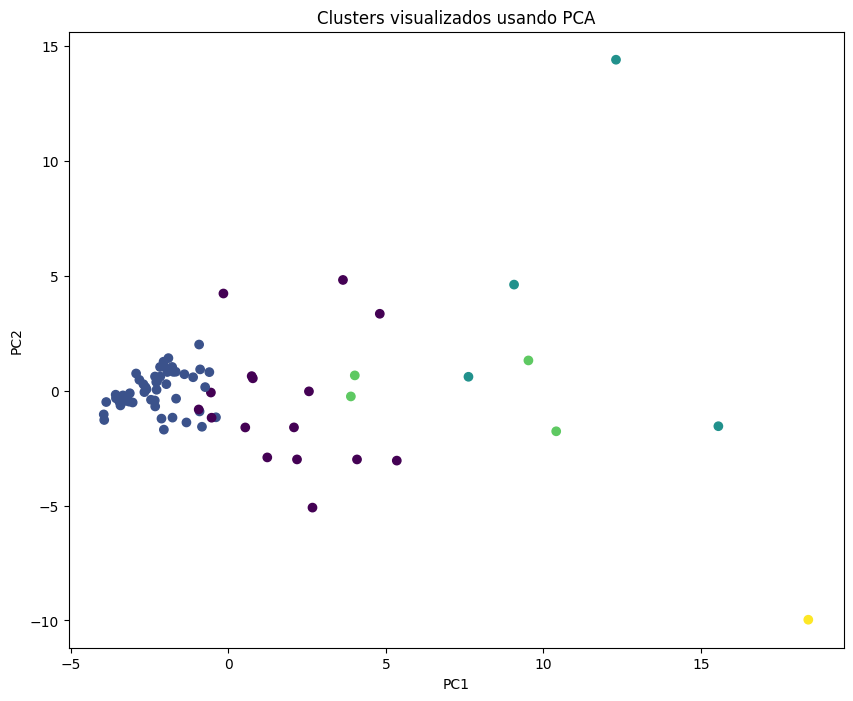

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Definir el número de clusters
num_clusters = 5

# Crear y ajustar el modelo K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

# Añadir las etiquetas de los clusters al DataFrame original
data['Cluster'] = kmeans.labels_

# Visualización usando PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Crear un DataFrame con los datos PCA
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Plotear los clusters
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', marker='o')
plt.title('Clusters visualizados usando PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


### Agglomerative Clustering

In [10]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendro = dendrogram(linkage_matrix, **kwargs)
    return dendro

In [11]:
from sklearn.preprocessing import StandardScaler

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
scaled_data

array([[ 0.24682643, -0.2330415 ,  0.07085507, ...,  1.02086055,
         1.49932171, -0.1091578 ],
       [-0.49031616, -0.33259739, -0.57049169, ...,  0.44140142,
        -0.01516054,  0.22762247],
       [-0.0571754 , -0.61517522,  0.13235407, ..., -1.01435967,
        -0.53036224,  0.44604192],
       ...,
       [-0.82706175, -0.64232683, -0.57927726, ..., -1.03076721,
        -0.53496851, -0.01988749],
       [-0.55537015, -0.06812063, -0.70227527, ..., -0.91308546,
        -0.4334916 ,  0.40976651],
       [ 0.77932053,  0.55737195,  0.42227795, ..., -0.70246399,
        -0.15110575, -0.33006274]])

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

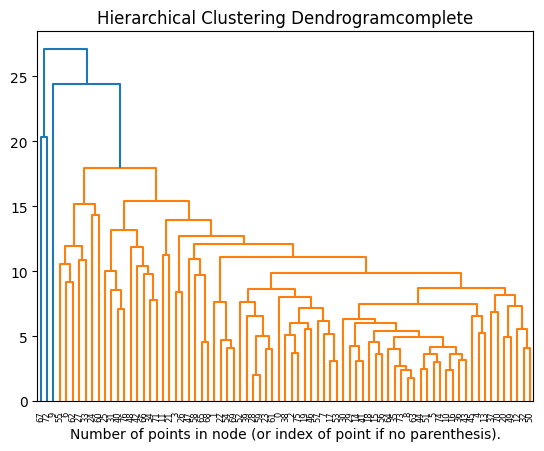

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# linkages = ("ward", "average", "complete", "single")

linkage = "complete"

clustering = AgglomerativeClustering(linkage=linkage, distance_threshold=0, n_clusters=None)
clustering = clustering.fit(scaled_data)


plt.title('Hierarchical Clustering Dendrogram' + linkage)
# plot the top three levels of the dendrogram
dendro = plot_dendrogram(clustering, truncate_mode="level", p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

In [13]:
# Extract the colors and the corresponding leaf order from the dendrogram
colors = dendro['leaves_color_list']
leaves = dendro['leaves']

# Create a DataFrame that matches the leaves to the colors
leaf_color_df = pd.DataFrame({'index': leaves, 'color': colors})
leaf_color_df.sort_values(by='index', inplace=True)

# Add the colors to the original data
data['dendrogram_color'] = leaf_color_df['color'].values

# Create a pairplot with the specified colors
sns.pairplot(data, hue='dendrogram_color', palette='tab10')
plt.show()
# data["cluster"]

KeyboardInterrupt: 

## Siamese NN

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from SNN.siamese_network_parse import PrepareDataSNN

# Definir la arquitectura base
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

# Definir la función de distancia
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Crear el modelo de red siamesa
def create_siamese_network(input_shape):
    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Obtener las representaciones de las dos ramas
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calcular la distancia entre las dos salidas
    distance = Lambda(euclidean_distance, output_shape=(1,))([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    return model

# Definir la función de pérdida
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Entrenar el modelo
def train_siamese_network(data_a, data_b, labels):
    input_shape = (data_a.shape[1],)
    model = create_siamese_network(input_shape)

    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

    model.fit([data_a, data_b], labels, batch_size=128, epochs=20)

# Ejecutar el entrenamiento
if __name__ == "__main__":
    data = PrepareDataSNN()
    data_a, data_b, labels = data.process()
    train_siamese_network(data_a, data_b, labels)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0000e+00   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 